In [1]:
from enum import Enum
import random
import math
from matplotlib import pyplot as plt
import numpy as np

In [2]:
class Action(Enum):
    UP = 1
    RIGHT = 2
    DOWN = 3
    LEFT = 4

In [3]:
class Grid:
    def __init__(self, num_rows, num_cols, change_time):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.change_time = change_time
        self.start = (num_rows - 1, num_cols - 6)
        self.goal = (0, num_cols - 1)
        self.blocked = set((3, i) for i in range(1, num_cols))
        self.state = self.start
        self.time = 0
    
    def __str__(self):
        grid = [['O'] * self.num_cols for _ in range(self.num_rows)] 
        start_row, start_col = self.start
        grid[start_row][start_col] = 'S'
        goal_row, goal_col = self.goal
        grid[goal_row][goal_col] = 'G'
        for row, col in self.blocked:
            grid[row][col] = 'B'
        grid = [''.join(row) for row in grid]
        return '\n'.join(grid)
        
        
    def take_action(self, a):
        row, col = self.state
        if a == Action.UP:
            row -= 1
        elif a == Action.DOWN:
            row += 1
        elif a == Action.RIGHT:
            col += 1
        elif a == Action.LEFT:
            col -= 1
        else:
            print('Unknown action!')
        row = min(max(0, row), self.num_rows - 1)
        col = min(max(0, col), self.num_cols - 1)
        if (row, col) not in self.blocked:
            self.state = (row, col)
        reward = 1 if self.state == self.goal else 0
        is_terminal = reward == 1
        self.time += 1
        if self.time == self.change_time:
            self.blocked.remove((3, self.num_cols - 1))
        return is_terminal, reward, self.state
    
    def reset(self):
        self.state = self.start

In [4]:
class DynaQPlus:
    def __init__(self, n, planning_exploration_bonus,
                 action_selection_exploration_bonus,
                 num_rows, num_cols,
                 epsilon=0.1, alpha=0.5, gamma=0.95):
        self.n = n
        self.action_selection_exploration_bonus = action_selection_exploration_bonus
        self.planning_exploration_bonus = planning_exploration_bonus
        self.states = [(row, col) for row in range(num_rows)
                       for col in range(num_cols)]
        state_action_pairs = [(state, action) for state in self.states
                              for action in list(Action)]
        self.action_values = {(state, action): 0
                              for state, action in state_action_pairs}
        self.model = {(state, action): (0, state)
                              for state, action in state_action_pairs}
        self.last_tried = {(state, action): 0
                          for state, action in state_action_pairs}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.time = 0
        
    def choose_action(self, state):
        self.time += 1
        if random.random() < self.epsilon:
            action = random.choice(list(Action))
        else:
            action = max(list(Action),
                       key=lambda a: self.action_values[(state, a)]
                        + self.action_selection_exploration_bonus
                        * math.sqrt(self.time_since(state, a)))
        self.last_tried[(state, action)] = self.time
        return action
        
    def update_action_value(self, old_state, action, reward, new_state):
        self.action_values[(old_state, action)] += self.alpha * (
            reward + self.gamma * max(
                self.action_values[(new_state, a)] for a in list(Action))
        - self.action_values[(old_state, action)])
        
    def time_since(self, state, action):
        return self.time - self.last_tried[state, action]
    
    def update_model(self, old_state, action, reward, new_state):
        self.model[(old_state, action)] = (reward, new_state)
    
    def plan(self):
        for _ in range(self.n):
            state = random.choice(self.states)
            action = random.choice(list(Action))
            reward, new_state = self.model[(state, action)]
            elapsed_time = self.time_since(state, action)
            reward += self.planning_exploration_bonus * math.sqrt(elapsed_time)
            self.update_action_value(state, action, reward, new_state)

In [5]:
def play(time_steps, num_rows, num_cols, agent):
    grid = Grid(num_rows=num_rows, num_cols=num_cols, change_time=3000)
    cum_rewards = []
    cum_reward = 0
    state = grid.state
    for _ in range(time_steps):
        action = agent.choose_action(state)
        is_terminal, reward, new_state = grid.take_action(action)
        agent.update_action_value(state, action, reward, new_state)
        agent.update_model(state, action, reward, new_state)
        agent.plan()
        if is_terminal:
            grid.reset()
        state = grid.state
        cum_reward += reward
        cum_rewards.append(cum_reward)
    return cum_rewards

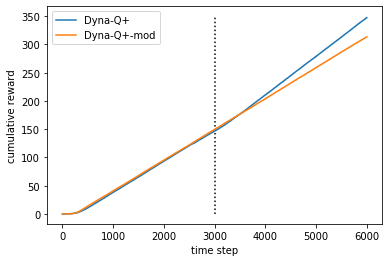

In [8]:
num_rows = 6
num_cols = 9
num_runs = 10
orig_res = []
mod_res = []
for _ in range(num_runs):
    orig_agent = DynaQPlus(n=50,
                  planning_exploration_bonus=0.001,
                  action_selection_exploration_bonus=0,
                  num_rows=num_rows,
                  num_cols=num_cols)
    res = play(6000, num_rows, num_cols, orig_agent)
    orig_res.append(res)
    mod_agent = DynaQPlus(n=50,
                  planning_exploration_bonus=0,
                  action_selection_exploration_bonus=0.001,
                  num_rows=num_rows,
                  num_cols=num_cols)
    res = play(6000, num_rows, num_cols, mod_agent)
    mod_res.append(res)
plt.plot(np.array(orig_res).mean(0))
plt.plot(np.array(mod_res).mean(0))
plt.xlabel('time step')
plt.ylabel('cumulative reward')
plt.legend(['Dyna-Q+', 'Dyna-Q+-mod'], loc='upper left')
plt.vlines(3000, 0, 350, linestyles='dotted')
plt.savefig('dyna.png')